# **Progetto IAA - Separazione di immagini**
**Author**: Roberto Zanolli

## Richieste:
- La rete neurale riceve in input l'immagine combinata e deve restituire le due immagini separate.
- Le prestazioni vengono valutate utilizzando l'errore quadratico medio (MSE) tra le immagini predette e quelle di riferimento.
- Entrambi i dataset sono in scala di grigi e tutti i campioni vengono adattati alla risoluzione (32,32).




---
## Import librerie e dataset
Viene fatto import dei moduli necessari e dei dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist, fashion_mnist
import tensorflow.image as tfi


## Caricamento dei dataset
Vengono caricati i dataset e vengono normalizzate le immagini.
(Operazioni prese dal notebook di specifiche)

- Vengono caricati i dataset MNIST e Fashion-MNIST.
- Le immagini vengono normalizzate (dividendo per 255) e viene aggiunto padding per ottenere la risoluzione (32,32).


In [2]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#normalizzazione dei dati di training e di test (per entrambi i dataset)
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Generazione di dati

- Viene creato un generatore di dati con batchsize=1 per visualizzare alcuni esempi di input-output.
- Viene definita una funzione show_images per visualizzare l'immagine combinata e le due immagini originali.


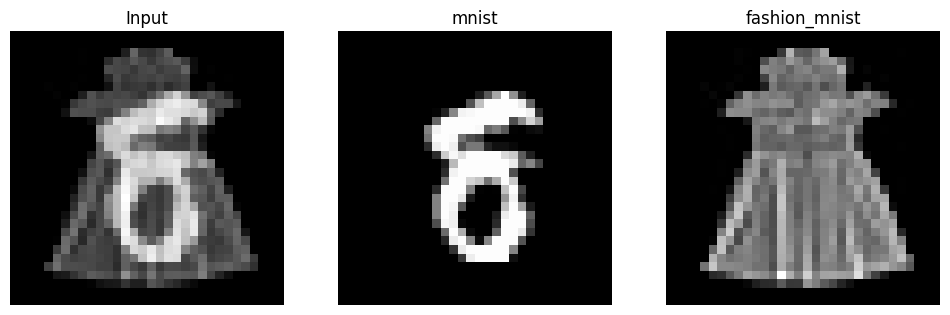

In [3]:
#generatore (randomicamente prende coppie di immagini e le somma)
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data


onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)


#show images --> plotting
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])



## Creazione del modello basato su CNN
Il modello CNN utilizza una struttura Encoder-Decoder, con l'inclusione di *skip connections* tra l'encoder e il decoder.

1. **Metrica di Loss:** È stata utilizzata la metrica `MSE` (Mean Squared Error).

2. **Funzione cnn_model:** La funzione `cnn_model` restituisce un modello Keras che utilizza l'architettura Encoder-Decoder con *skip connections*.

### Architettura del modello
Il modello è costituito da una rete neurale convoluzionale (CNN) con un'architettura Encoder-Decoder, in cui vengono utilizzate delle connessioni di salto tra le fasi di encoding e decoding per migliorare la ricostruzione dell'immagine.

---

### 1. Encoder (compressione dell'informazione)
L'encoder estrae le caratteristiche principali dell'immagine e riduce la sua dimensione spaziale, mantenendo solo le informazioni più importanti.

1. **Convoluzione (64 filtri, 3×3)**
   - Applica 64 filtri (3x3) all'immagine di input (32x32x1).
   - I filtri rilevano pattern locali come bordi e texture.
2. **BatchNormalization**
   - Normalizza i dati in ingresso per migliorare la stabilità e la convergenza del modello.
3. **MaxPooling (2×2)**
   - Riduce la dimensione spaziale da (32x32) a (16x16).
4. **Convoluzione (128 filtri, 3×3)**
   - Estrae caratteristiche più complesse rispetto allo strato precedente.
5. **BatchNormalization**
   - Normalizza le attivazioni per migliorare l'apprendimento.
6. **MaxPooling (2×2)**
   - Riduce ulteriormente la dimensione spaziale a (8x8).

---

### 2. Bottleneck (rappresentazione compatta)
Questa sezione rappresenta la forma più compatta dell'immagine, mantenendo solo le informazioni essenziali.

- **Convoluzione (256 filtri, 3×3)**
  - Aumenta la capacità di rappresentazione del modello.
  - Mantiene la dimensione (8x8) ma aumenta la profondità a 256 canali.
- **BatchNormalization**
  - Garantisce che le attivazioni siano più stabili.

---

### 3. Decoder (ricostruzione dell'immagine)
Il decoder espande progressivamente la rappresentazione compressa fino a ricostruire un'immagine delle stesse dimensioni dell'input.

1. **Convoluzione Trasposta (128 filtri, 3×3)**
   - Inizia la ricostruzione portando la profondità a 128 canali.
2. **BatchNormalization**
   - Normalizza per migliorare l'efficienza dell'addestramento.
3. **UpSampling (2×2)**
   - Aumenta la dimensione da (8x8) a (16x16).
4. **Concatenazione con x2**  
   - Si aggiunge una *skip connection* da x2 (livello dell'encoder) per migliorare il recupero delle caratteristiche.

5. **Convoluzione Trasposta (64 filtri, 3×3)**
   - Continua la ricostruzione con 64 filtri.
6. **BatchNormalization**
   - Normalizza le attivazioni.
7. **UpSampling (2×2)**
   - Aumenta la dimensione da (16x16) a (32x32).
8. **Concatenazione con x1**  
   - Aggiunta di un'altra *skip connection* da x1 (livello dell'encoder) per preservare le informazioni cruciali nella ricostruzione.

---

### 4. Output (generazione delle immagini ricostruite)
Il modello produce due immagini di output, entrambe con le stesse dimensioni dell'input (32x32).

---

### 5. Compilazione
- **Ottimizzatore:** Adam (learning rate = 0.0005)
- **Funzione di perdita:** Mean Squared Error (MSE), come richiesto.

In [4]:


# modello basato su CNN
#effettuando prova con e senza batch normalization si nota che normalizzando si ottiene un mse minore

def cnn_model():
    input_img = layers.Input(shape=(32, 32, 1))

    # encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x1 = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = layers.BatchNormalization()(x)
    x2 = layers.MaxPooling2D((2, 2), padding='same')(x)

    # bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    x = layers.BatchNormalization()(x)

    # decoder
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x = layers.BatchNormalization()(x)
    x2 = layers.UpSampling2D((2, 2))(x2)
    x = layers.Concatenate()([x, x2])  # Skip connection da x2

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.UpSampling2D((2,2))(x1)
    x = layers.Concatenate()([x, x1])  # Skip connection da x1


    output1 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output1')(x)
    output2 = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output2')(x)

    model = models.Model(input_img, [output1, output2])

    # Compilazione del modello
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mean_squared_error', metrics=['mean_squared_error', 'mean_squared_error'])

    return model



## Addestramento del modello
É stato creato un insieme di dati di input usando un batchsize = 128.


Si é definito un learning rate scheduler ed un early stopping per cercare di migliorare le prestazioni e l'efficienza del modello.


É stato addestrato il modello con questi dati (il numero di epochs e il batchsize possono essere scelti).



In [5]:
#INSERIRE NUMERO DI EPOCHS e BATCHSIZE
eps = 25
batch_size = 128

# creazione e addestramento del modello
model = cnn_model()

testgen = datagenerator(mnist_x_train, fashion_mnist_x_train, batch_size)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

# implementazione learning rate optimizer e early stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

model.fit(testgen, steps_per_epoch=1000, epochs=eps, verbose=1, callbacks=[reduce_lr, early_stopping])


Epoch 1/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - loss: 0.0292 - output1_loss: 0.0132 - output1_mean_squared_error: 0.0132 - output2_loss: 0.0160 - output2_mean_squared_error: 0.0160 - learning_rate: 5.0000e-04
Epoch 2/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - loss: 0.0075 - output1_loss: 0.0030 - output1_mean_squared_error: 0.0030 - output2_loss: 0.0044 - output2_mean_squared_error: 0.0044 - learning_rate: 5.0000e-04
Epoch 3/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0061 - output1_loss: 0.0025 - output1_mean_squared_error: 0.0025 - output2_loss: 0.0036 - output2_mean_squared_error: 0.0036 - learning_rate: 5.0000e-04
Epoch 4/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0052 - output1_loss: 0.0021 - output1_mean_squared_error: 0.0021 - output2_loss: 0.0031 - output2_mean_squared_error: 0.0031 - learning_rate: 5.0000e-04
Epoch 5/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - loss: 0.0047 - output1_loss: 0.0019 - output1_mean_squared_error: 

## Evaluation del modello

Come da notebook di specifiche.

Sono state aggiunte operazioni di squeeze per rimuovere le dimensioni di lunghezza 1 per assicurarsi che y e pred abbiano stessa dim.

- Definisce una funzione per valutare il
modello calcolando l'MSE tra le immagini previste e quelle originali.
- Valuta ripetutamente il modello e stampa l'MSE medio e la deviazione standard.


In [6]:


def eval_model(model):
    x, (y1, y2) = next(testgen)
    pred1, pred2 = model(x)
    # squeeze per
    pred1 = np.squeeze(pred1)
    pred2 = np.squeeze(pred2)
    y1 = np.squeeze(y1)
    y2 = np.squeeze(y2)

    return ( np.mean((pred1 - y1) ** 2) + np.mean((pred2 - y2) ** 2)) / 2


repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
    eval_results.append(eval_model(model))

print("MSE =", np.mean(eval_results))
print("Standard deviation =", np.std(eval_results))


MSE = 0.0013084886544925736
Standard deviation = 8.885867949185789e-05


## Plotting di qualche predizione
Stampa di immagine input affiancata dalle  due immagini originali e dalle tue predizioni rispettivamente pred1 (mnist) e pred2 (fashionmnist).

(Per tentare di osservare ad occhio nudo l'accettabilitá delle predizioni dato l'imput)

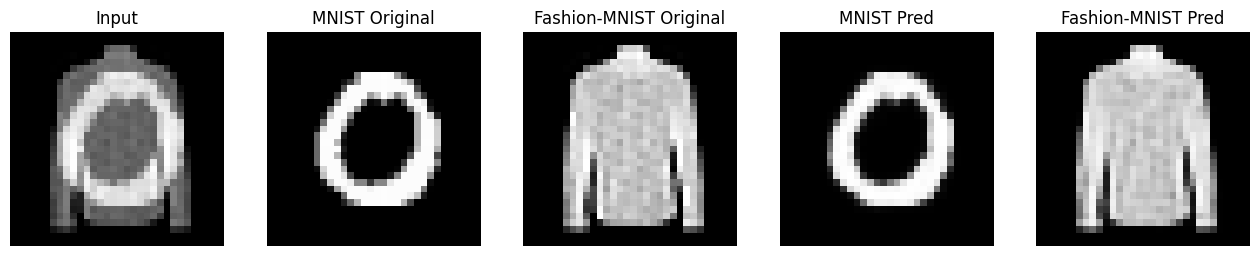

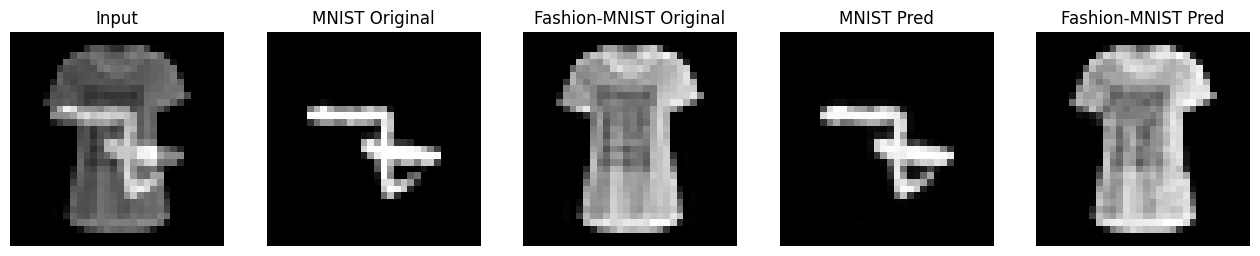

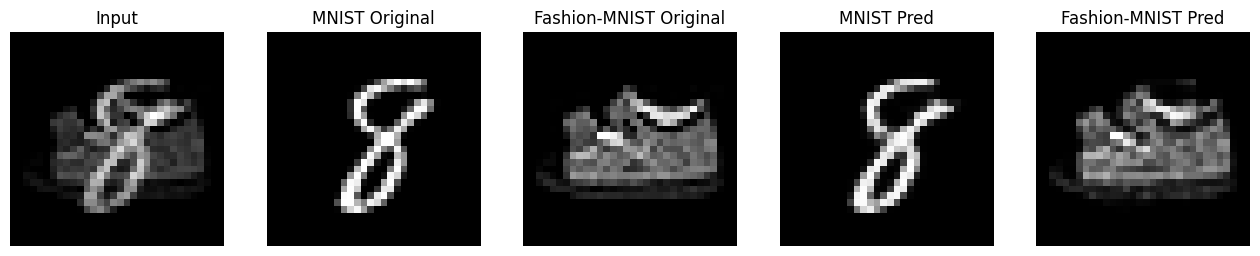

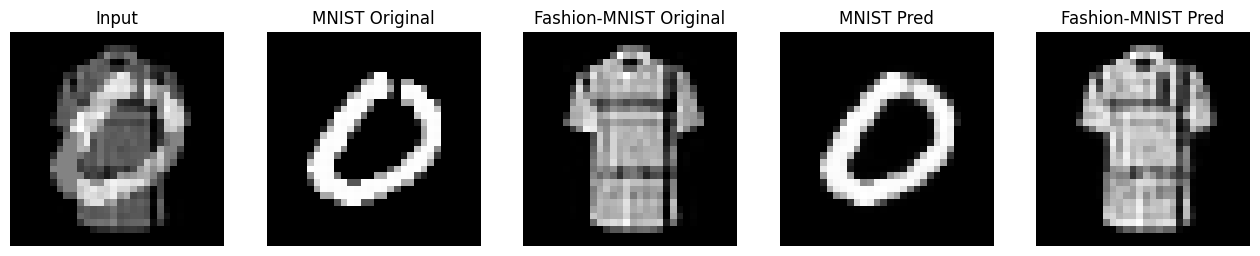

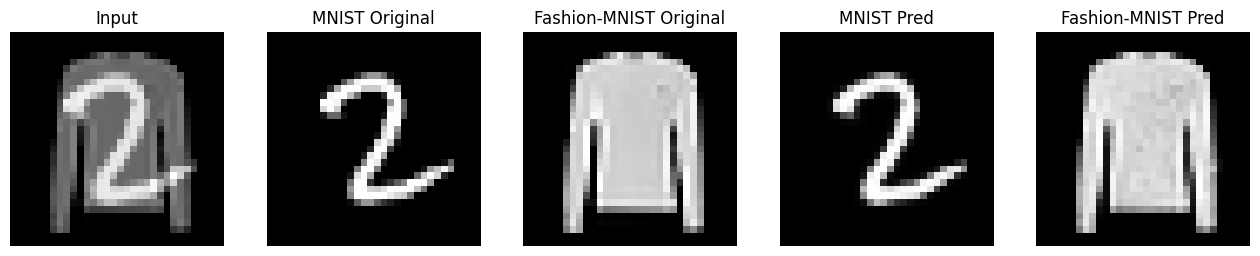

In [7]:
def plot_predictions(model, num_examples=5):
  for i in range(num_examples):
    x, (y1, y2) = next(onegen) # Ottieni un esempio dal generatore
    pred1, pred2 = model.predict(x, verbose=0) # Ottieni le predizioni dal modello

    # Rimuove le dimensioni extra
    x = np.squeeze(x[0])
    y1 = np.squeeze(y1[0])
    y2 = np.squeeze(y2[0])
    pred1 = np.squeeze(pred1[0])
    pred2 = np.squeeze(pred2[0])

    # Visualizzazione delle immagini
    fig, ax = plt.subplots(1, 5, figsize=(16, 4))
    ax[0].imshow(x, cmap='gray')
    ax[0].set_title("Input")
    ax[0].axis('off')

    ax[1].imshow(y1, cmap='gray')
    ax[1].set_title("MNIST Original")
    ax[1].axis('off')

    ax[2].imshow(y2, cmap='gray')
    ax[2].set_title("Fashion-MNIST Original")
    ax[2].axis('off')

    ax[3].imshow(pred1, cmap='gray')
    ax[3].set_title("MNIST Pred")
    ax[3].axis('off')

    ax[4].imshow(pred2, cmap='gray')
    ax[4].set_title("Fashion-MNIST Pred")
    ax[4].axis('off')
  plt.show()
# Chiamata della funzione per visualizzare le immagini e le predizioni
plot_predictions(model)
